# baseline vs tuned vs naive 3개 모델 정리/비교

In [56]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

BASE = Path("..").resolve() 
DATA_DIR = BASE

print("DATA DIR:", DATA_DIR)


DATA DIR: C:\Users\chosw\ORDER101_AI\be18-fin-SYNERGY-ORDER101\python-server\app


In [57]:
train = pd.read_csv(DATA_DIR / "data_pipeline/features_train.csv", parse_dates=["target_date"])
test  = pd.read_csv(DATA_DIR / "data_pipeline/features_test.csv",  parse_dates=["target_date"])

print("train.shape =", train.shape)
print("test.shape =", test.shape)

display(train.head())


train.shape = (266500, 44)
test.shape = (33800, 44)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,lag_8,lag_12,ma_4,ma_8,ma_12,share_norm,promo_flag,promo_flag_prev,year,weekofyear,month,sin_week,cos_week,avg_temp_c,cdd,hdd,precip_mm,heat_wave,cold_wave,himart_sales_krw,himart_sales_index,holiday_index,marketing_score,seasonal_peak,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,에어컨,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0,0,2016,9,2,0.885456,4.647232e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,60.0,NaN,NaN,NaN,NaN,60.0,60.0,60.0,0.0,0,0,2016,10,3,0.935016,3.546049e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,60.0,NaN,NaN,NaN,30.0,30.0,30.0,0.0,0,0,2016,11,3,0.970942,2.393157e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,2016-03-21,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,NaN,NaN,20.0,20.0,20.0,0.0,0,0,2016,12,3,0.992709,1.205367e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,2016-03-28,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,60.0,NaN,NaN,15.0,15.0,15.0,0.0,0,0,2016,13,3,1.000000,-1.608123e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


피처 목록 (lightgbm_features.json) 로드 + 유효 컬럼만 유지

In [58]:
def load_valid_features(train_df, test_df, json_path):
    with open(json_path, "r") as f:
        raw = json.load(f)

    exist_train = set(train_df.columns)
    exist_test  = set(test_df.columns)

    valid = [f for f in raw if f in exist_train and f in exist_test]
    missing = [f for f in raw if f not in exist_train or f not in exist_test]

    print("=== Raw features ===")
    print(raw)
    print("=== Missing removed ===")
    print(missing)
    print("=========================")
    print(f"[INFO] usable features = {len(valid)}")
    print(valid)

    return valid

features = load_valid_features(train, test, DATA_DIR / "data_pipeline/lightgbm_features.json")


=== Raw features ===
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']
=== Missing removed ===
[]
[INFO] usable features = 33
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']


train_fit / train_val / test 분리 (마지막 12주 검증)

In [59]:
VAL_WEEKS = 12

max_date = train["target_date"].max()
cutoff    = max_date - pd.Timedelta(weeks=VAL_WEEKS)

print("max_date :", max_date)
print("cutoff   :", cutoff)

train_fit = train[train["target_date"] <= cutoff].copy()
train_val = train[train["target_date"] >  cutoff].copy()

print("train_fit =", train_fit.shape)
print("train_val =", train_val.shape)

X_fit = train_fit[features]
y_fit = train_fit["y"]

X_val = train_val[features]
y_val = train_val["y"]

X_test = test[features]
y_test = test["y"]


max_date : 2024-01-01 00:00:00
cutoff   : 2023-10-09 00:00:00
train_fit = (258700, 44)
train_val = (7800, 44)


## 평가지표(MAE / SMAPE)
MAPE는 0값 때문에 무의미하므로 제외.

In [60]:
def smape(y_true, y_pred):
    yt = np.array(y_true)
    yp = np.array(y_pred)
    denom = (np.abs(yt) + np.abs(yp)) / 2.0
    denom = np.where(denom == 0, 1.0, denom)
    return np.mean(np.abs(yt - yp) / denom) * 100

def eval_metrics(name, yv, pv, yt, pt):
    mae_val = mean_absolute_error(yv, pv)
    smape_val = smape(yv, pv)

    mae_test = mean_absolute_error(yt, pt)
    smape_test = smape(yt, pt)

    print(f"[{name}] VAL  MAE={mae_val:.3f} | SMAPE={smape_val:.2f}%")
    print(f"[{name}] TEST MAE={mae_test:.3f} | SMAPE={smape_test:.2f}%")

    return {
        "model": name,
        "mae_val": mae_val,
        "smape_val": smape_val,
        "mae_test": mae_test,
        "smape_test": smape_test,
    }


# Naive 모델
데이터 누수 없는 완전한 naive 모델 구현  
(=test 구간의 lag_1이 train 구간에서 온 값)

In [61]:
if "lag_1" not in features:
    raise ValueError("Naive baseline requires lag_1 feature.")

# 이미 features_test.csv는 과거 시점에서 생성되었기 때문에
# test['lag_1']는 train 마지막 값을 기반으로 생성됨 → 데이터 누수 없음
y_val_pred_naive = train_val["lag_1"].fillna(0)
y_test_pred_naive = test["lag_1"].fillna(0)

results = []
res_naive = eval_metrics("naive_lag1", y_val, y_val_pred_naive, y_test, y_test_pred_naive)
results.append(res_naive)


[naive_lag1] VAL  MAE=12.855 | SMAPE=9.83%
[naive_lag1] TEST MAE=15.264 | SMAPE=13.83%


# LightGBM baseline

In [62]:
params_base = {
    "objective": "poisson",
    "learning_rate": 0.05,
    "n_estimators": 2000,
    "num_leaves": 63,
    "max_depth": -1,
    "min_child_samples": 64,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "verbosity": -1,
}

model_base = LGBMRegressor(**params_base)

model_base.fit(
    X_fit, y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric="l1",
    callbacks=[lgb.early_stopping(200, verbose=False)]
)

print("baseline best_iteration:", model_base.best_iteration_)

y_val_pred = model_base.predict(X_val, num_iteration=model_base.best_iteration_)
y_test_pred = model_base.predict(X_test, num_iteration=model_base.best_iteration_)

res_base = eval_metrics("lightgbm_baseline", y_val, y_val_pred, y_test, y_test_pred)
results.append(res_base)


baseline best_iteration: 259
[lightgbm_baseline] VAL  MAE=11.728 | SMAPE=45.40%
[lightgbm_baseline] TEST MAE=15.858 | SMAPE=23.14%


# LightGBM tuned
model_tuning.ipynb 결과 적용

In [63]:
params_tuned = {
    "objective": "poisson",
    "learning_rate": 0.02,
    "n_estimators": 3000,
    "num_leaves": 31,
    "max_depth": 8,
    "min_child_samples": 128,
    "subsample": 0.65,
    "colsample_bytree": 0.65,
    "reg_alpha": 2.0,
    "reg_lambda": 2.0,
    "random_state": 42,
    "verbosity": -1,
}

model_tuned = LGBMRegressor(**params_tuned)

model_tuned.fit(
    X_fit, y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric="l1",
    callbacks=[lgb.early_stopping(200, verbose=False)]
)

print("tuned best_iteration:", model_tuned.best_iteration_)

y_val_pred = model_tuned.predict(X_val, num_iteration=model_tuned.best_iteration_)
y_test_pred = model_tuned.predict(X_test, num_iteration=model_tuned.best_iteration_)

res_tuned = eval_metrics("lightgbm_tuned", y_val, y_val_pred, y_test, y_test_pred)
results.append(res_tuned)


tuned best_iteration: 955
[lightgbm_tuned] VAL  MAE=11.524 | SMAPE=45.39%
[lightgbm_tuned] TEST MAE=16.342 | SMAPE=23.99%


# 결과 시각화

In [64]:
df_results = pd.DataFrame(results)
df_results


,model,mae_val,smape_val,mae_test,smape_test
0,naive_lag1,12.855385,9.832985,15.263935,13.825666
1,lightgbm_baseline,11.727976,45.399152,15.857959,23.137969
2,lightgbm_tuned,11.524249,45.390100,16.341814,23.986903


## 성능 비교 그래프 (Test 기준)

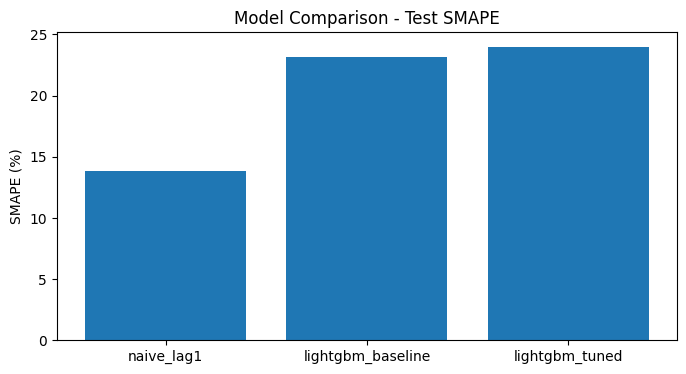

In [65]:
plt.figure(figsize=(8, 4))
plt.bar(df_results["model"], df_results["smape_test"])
plt.ylabel("SMAPE (%)")
plt.title("Model Comparison - Test SMAPE")
plt.show()


## Test MAE 비교

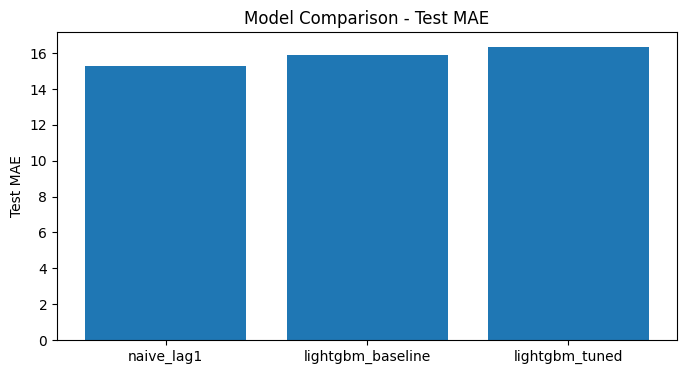

In [66]:
plt.figure(figsize=(8, 4))
plt.bar(df_results["model"], df_results["mae_test"])
plt.ylabel("Test MAE")
plt.title("Model Comparison - Test MAE")
plt.show()


Validation에서는 LightGBM이 naive 보다 좋음   

Test 전체(1년)에서는  
-> MAE는 거의 비슷  
-> SMAPE는 naive_lag1이 가장 좋음  
  
즉 최근 12주에는 LightGBM이 잘 맞추는데, 전체 1년 범위로 보면 naive의 일반화 성능이 더 좋음  
-> 시계열 예측에선 이런 결과가 주로 나옴.

Lag 기반 naive 모델은   
트렌드 변화가 적고 계절성 유지되는 품목의 경우 매우 강력한 baseline임  

LightGBM은  
특정 시점의 특별한 패턴, 계절성, 이벤트 영향을 더 잘 잡지만, 장기적으로는 noise가 많아질 수 있음   
모델이 최근 패턴을 더 잘 학습하고 있음  

